## Логистическая регрессия

In [653]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Реализуйте обучение логистической регрессии с $L^1$ и $L^2$ регуляризацией с помощью метода Stochastic Gradient Descent (SGD)

#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

In [654]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import shuffle as sh

#SGD использует для расчета градиента только 1 объект за итерацию
#Создадим генератор, выдающию нам нужное количество батчей из выборки
def batch_generator(X, y, shuffle=True, batch_size=1):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    if(shuffle):
        X, y = sh(X, y)
    
    X_batch = X
    y_batch = y
    n = X.shape[0] // batch_size
    for i in range(n):
        X_batch = X[int(batch_size * i) : int(batch_size * (i + 1)), :]
        y_batch = y[int(batch_size * i) : int(batch_size * (i + 1))]
        yield (X_batch, y_batch)



class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, batch_generator, C=1, alpha=0.01, max_epoch=10, penalty='l2', fit_intercept=True):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.penalty = penalty
        self.batch_generator = batch_generator
        self.fit_intercept = fit_intercept
        self.batch_errors = {'batch_num' : [], 'loss' : []}
    
    def __add_intercept(self, X):
        '''при необходимости добавляем значения пересечения с осями'''
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
        
    def sigmoid(self,z):
        '''возвращает вероятность принадлежности к классу для определенного объекта'''
        return 1 / (1 + np.exp(-z))
    
    def loss(self,X_batch,y_batch):
        '''считает ошибку по батчу'''
        z = np.dot(X_batch, self.weights)
        h = self.sigmoid(z)
        loss = 0
        #для SGD размер батча будет всегда 1
        
        loss =  np.sum(y_batch * np.log(h) + (1 - y_batch) * np.log(1 - h))
        #применяем нужную регуляризацию
        if self.penalty == 'l2':
            loss = -1./X_batch.shape[0] * loss + np.sum(self.weights**2)/self.C
        else:
            loss = -1./X_batch.shape[0] * loss + np.sum(np.abs(self.weights))/self.C
        return loss
    
    def gradient(self, X_batch, y_batch):
        '''возвращает градиент по батчу'''
        z = np.dot(X_batch, self.weights)
        h = self.sigmoid(z)
        N = X_batch.shape[0]
        gradient = (1/N) * np.dot( (h - y_batch),X_batch ) + np.sign(self.weights) / self.C
        return gradient
    
    def update_weights(self, gradient):
        self.weights = self.weights - self.alpha * gradient
        return self
    
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        if self.fit_intercept:
            X = self.__add_intercept(X)
        #случайным образом инициализируем выеса
        self.weights =  np.random.uniform(-1. / X.shape[0], 1. / X.shape[0], X.shape[1]) 
        #запускаем механизм обучения модели. Проходимся по всем объектам батча в каждой эпохе.Размер батча в нашем случае будем всегда 1
        for i in range(1,self.max_epoch+1):
            #инициализируем наш генератор батчей
            new_epoch_generator = self.batch_generator(X, y)
            for i, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0] #0 -индекс X
                y_batch = new_batch[1] #1 -индекс Y
                #считаем градиент для данного батча
                gradient = self.gradient(X_batch, y_batch)
                #обновляем веса
                self.update_weights(gradient)
                #считаем потери по батчу
                loss = self.loss(X_batch, y_batch) 
            self.batch_errors['batch_num'].append(i)
            self.batch_errors['loss'].append(loss)

        return self
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
    
        return self
        
    def predict(self, X, threshold = 0.5):
        '''
        Возвращение метки класса
        '''
        y_hat =  (self.predict_prob(X) >= threshold) * 1
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        if self.fit_intercept:
            X = self.__add_intercept(X)
        y_hat_proba = self.sigmoid(np.dot(X, self.weights))

        return y_hat_proba

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

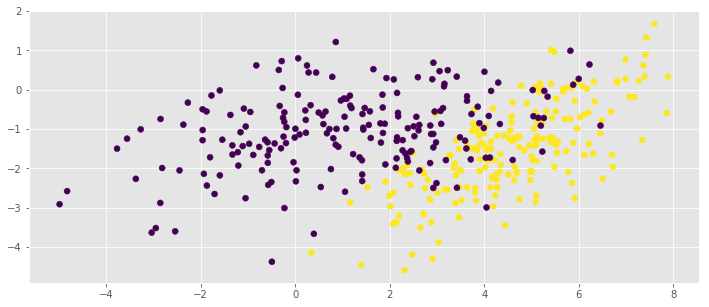

In [655]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y);

In [656]:
model = MySGDClassifier(batch_generator,C=100)
scaler = StandardScaler()
X = scaler.fit_transform(X)
model.fit(X, y)

MySGDClassifier(C=100, alpha=0.01,
        batch_generator=<function batch_generator at 0x0000027627A14730>,
        fit_intercept=True, max_epoch=10, penalty='l2')

In [657]:
## выводим полученные веса
model.weights

array([-0.21643191,  2.47703214, -1.16751664])

In [658]:
def plot_decision_boundary(model):
    ## Your code Here
    w = model.weights
    x = np.linspace(-3,2,100)
    y = -w[0]/w[2] - (w[1] * x)/w[2]
    plt.plot(x, y)

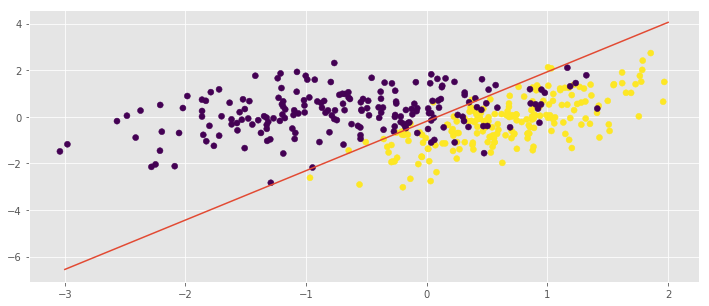

In [659]:
plt.scatter(X[:,0], X[:,1], c=y)
plot_decision_boundary(model)

## Анализ сходимости

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/эпохи (выбрать одно) для разных `alpha`.

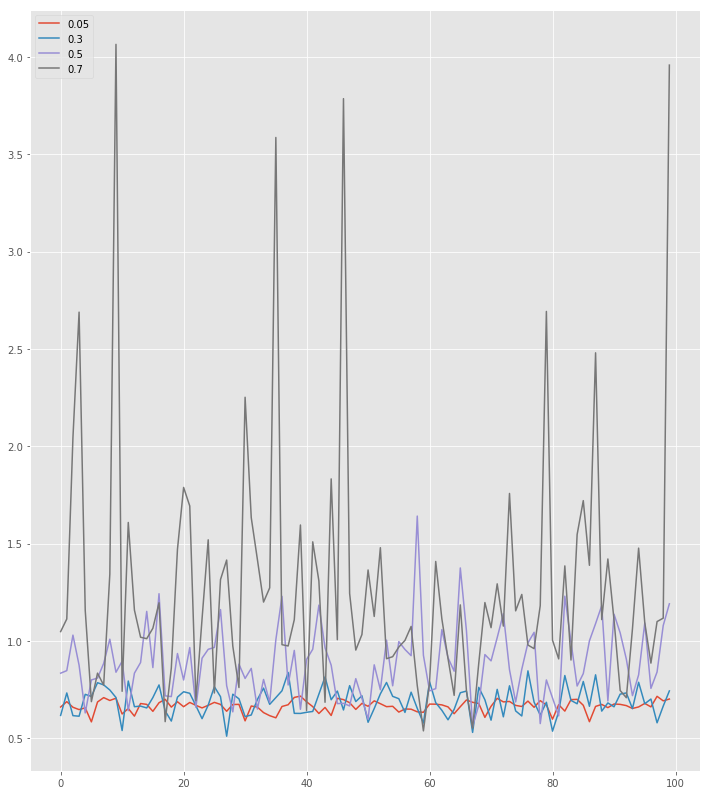

In [660]:

alpha = [0.05, 0.3, 0.5, 0.7]
plt.figure(figsize=(12, 14))
loss=[]
for i in alpha:
    clf = MySGDClassifier(batch_generator, alpha=i, max_epoch=100)
    clf.fit(X, y)     
    plt.plot(clf.batch_errors['loss'])
plt.legend(alpha_)
axes = plt.gca()
plt.show()